In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

C:\Users\celes\anaconda3\lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
""" The following code show how to get stock data from yfinance and then compute two well known indices:
 RSI - Relative Strength Index
 MFI - Money Flow Index. """

' The following code show how to get stock data from yfinance and then compute two well known indices:\n RSI - Relative Strength Index\n MFI - Money Flow Index. '

### Get Stock Data

In [28]:
ticker = 'JUN3.F' ### stock ticker
#ticker = 'JEN.F'
#ticker = '4A3.F'

data = []
data = yf.download(ticker, start='2022-01-01', end='2025-02-14', progress=False)
data = data[['Close','High','Low', 'Volume']] ### To compute RSI and MFI we only need these quantities

### Fill Forward -- Weekends and periods where the market ist not operating, for example weekends.
idx = pd.date_range(data.index[0], data.index[-1])
data = data.reindex(idx)
data.ffill(inplace=True)

data.head()

,Close,High,Low,Volume
2022-01-03,45.119999,45.119999,45.119999,10.0
2022-01-04,45.500000,45.500000,45.500000,0.0
2022-01-05,46.040001,46.040001,46.040001,18.0
2022-01-06,44.400002,44.400002,44.400002,0.0
2022-01-07,44.599998,44.599998,44.599998,0.0


### RSI - Relative Strength Index

In [29]:
### RSI - Relative Strength Index

### https://wire.insiderfinance.io/calculate-rsi-with-python-and-yahoo-finance-c8fb78b1c199

window = 14 ### how many past days to consider in the exponentially weighted calculations.
adjust = False

delta = []
delta = data['Close'].diff(1) ### compute the price difference

loss = delta.copy()
gains = delta.copy()

gains[gains < 0] = 0
loss[loss > 0] = 0

gain_ewm = gains.ewm(com=window - 1, adjust=adjust).mean()
loss_ewm = abs(loss.ewm(com=window - 1, adjust=adjust).mean())

RS = []
RS = gain_ewm / loss_ewm

RSI = []
RSI = 100 - 100 / (1 + RS)
RSI = pd.DataFrame(RSI)
RSI.rename(columns={"Close": "RSI"}, inplace=True)

data = data.join(RSI) ### append RSI to data

data.head()

,Close,High,Low,Volume,RSI
2022-01-03,45.119999,45.119999,45.119999,10.0,NaN
2022-01-04,45.500000,45.500000,45.500000,0.0,100.000000
2022-01-05,46.040001,46.040001,46.040001,18.0,100.000000
2022-01-06,44.400002,44.400002,44.400002,0.0,75.626384
2022-01-07,44.599998,44.599998,44.599998,0.0,76.382381


### MFI - Money Flow Index

In [30]:
### https://www.investopedia.com/terms/m/mfi.asp
### https://en.wikipedia.org/wiki/Money_flow_index

### Calculate the typical price and money flow

typical_price = []
typical_price  = data[['Close', 'High', 'Low']].sum(axis=1)/3 ### (Close + High + Low)/3

money_flow = []
money_flow = typical_price * data['Volume']

### For each period, mark whether the typical price was higher or lower than the prior period. 
### This will tell you whether raw money flow is positive or negative.

### Positive money flow is calculated by adding the money flow of all the 
### days where the typical price is higher than the previous day's typical price.

positive_flow = []
negative_flow = []

# Loop through the typical price
for i in range(0, len(typical_price)):

    if i == 0: ### money flow is not defined (there is no "previous typical price")
        positive_flow.append(0)
        negative_flow.append(0)

    else:
        if typical_price[i] > typical_price[i-1]:
            positive_flow.append(money_flow[i])
            negative_flow.append(0)

        elif typical_price[i] < typical_price[i-1]:
            negative_flow.append(money_flow[i])
            positive_flow.append(0)

        else:
            positive_flow.append(0)
            negative_flow.append(0)

positive_flow = pd.Series(positive_flow)
negative_flow = pd.Series(negative_flow)

# Get all of the positive and negative money flows within the time period

positive_mf = []
negative_mf = []

positive_mf = positive_flow.ewm(com=window - 1, adjust=adjust).mean()
negative_mf = negative_flow.ewm(com=window - 1, adjust=adjust).mean()

# Calculate the money flow index

MFI = []
MFI = 100 * (np.array(positive_mf) / (np.array(positive_mf) + np.array(negative_mf) ))
MFI = pd.DataFrame(MFI, columns=['MFI'])
MFI.set_index([data.index],inplace=True)

data = data.join(MFI) ### append MFI to data

data.head()

C:\Users\celes\AppData\Local\Temp\ipykernel_8260\2587815473.py:55: RuntimeWarning: invalid value encountered in divide
  MFI = 100 * (np.array(positive_mf) / (np.array(positive_mf) + np.array(negative_mf) ))


,Close,High,Low,Volume,RSI,MFI
2022-01-03,45.119999,45.119999,45.119999,10.0,NaN,NaN
2022-01-04,45.500000,45.500000,45.500000,0.0,100.000000,NaN
2022-01-05,46.040001,46.040001,46.040001,18.0,100.000000,100.0
2022-01-06,44.400002,44.400002,44.400002,0.0,75.626384,100.0
2022-01-07,44.599998,44.599998,44.599998,0.0,76.382381,100.0


### Plot Output

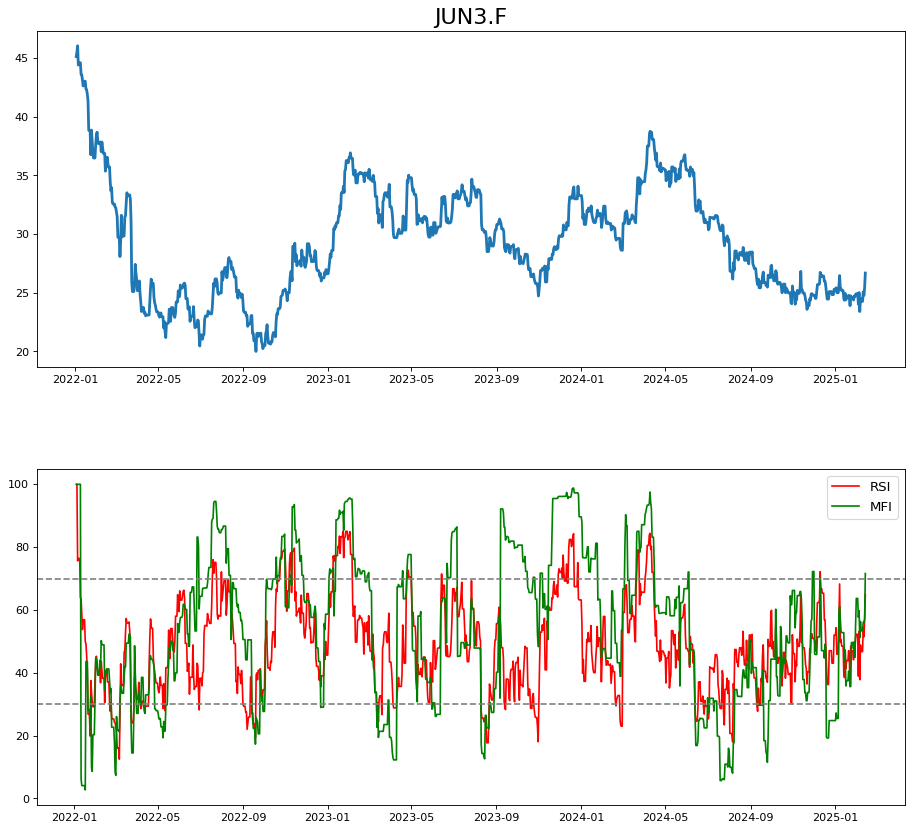

In [31]:
figure(figsize=(14, 14), dpi=80)

ax1 = plt.subplot2grid((10, 1), (0, 0), rowspan=4, colspan=1)
ax2 = plt.subplot2grid((10, 1), (5, 0), rowspan=4, colspan=1)
ax1.plot(data['Close'], linewidth=2.5)
ax1.set_title(ticker, fontsize=20)
ax2.plot(data['RSI'], color='red', linewidth=1.5)
ax2.plot(data['MFI'], color='green', linewidth=1.5)
ax2.axhline(30, linestyle='--', linewidth=1.5, color='grey')
ax2.axhline(70, linestyle='--', linewidth=1.5, color='grey')
ax2.legend(['RSI', 'MFI'], fontsize=12)

plt.show()